## 1. 数据预处理（Data Preprocessing）

### 1.1 读取与清洗

- 使用分号分隔读取数据
- 合并 Date 和 Time 为 datetime
- 替换缺失值 `?` 并转换为 float



In [2]:
import pandas as pd
import numpy as np

# 读取数据（不自动合并时间列）
df = pd.read_csv("household_power_consumption.txt", sep=';', na_values='?', low_memory=False)

# 合并 Date 和 Time 列为 datetime
df["Datetime"] = pd.to_datetime(df["Date"] + ' ' + df["Time"], dayfirst=True, format='%d/%m/%Y %H:%M:%S')

# 设置时间索引
df.set_index("Datetime", inplace=True)

# 删除原始的 Date 和 Time 列
df.drop(columns=["Date", "Time"], inplace=True)

# 转换所有数据为 float
df = df.astype("float32")

df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0


### 1.2 缺失值处理与下采样

- 对缺失值进行线性插值
- 下采样为 10 分钟粒度


In [3]:
# 时间插值填补缺失
df = df.interpolate(method='time')

# 下采样为 10 分钟平均
df_10min = df.resample("10min").mean()

df_10min.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:20:00,4.587333,0.4840,234.366653,19.699999,0.0,1.333333,16.833334
2006-12-16 17:30:00,4.252200,0.4608,234.208008,18.280001,0.0,1.100000,16.799999
2006-12-16 17:40:00,4.721600,0.0308,234.845001,20.260000,0.0,0.000000,16.900000
2006-12-16 17:50:00,3.476200,0.0424,235.044998,14.800000,0.0,0.000000,16.900000
2006-12-16 18:00:00,4.690400,0.1526,234.975006,20.080000,0.0,23.600000,16.900000


### 1.3 特征工程

- 提取时间相关特征（小时、星期几、是否周末）
- 添加周期性编码


In [4]:
df_10min["hour"] = df_10min.index.hour
df_10min["dayofweek"] = df_10min.index.dayofweek
df_10min["is_weekend"] = (df_10min["dayofweek"] >= 5).astype(int)

# 周期性特征（小时）
df_10min["hour_sin"] = np.sin(2 * np.pi * df_10min["hour"] / 24)
df_10min["hour_cos"] = np.cos(2 * np.pi * df_10min["hour"] / 24)

df_10min.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,is_weekend,hour_sin,hour_cos
Datetime,,,,,,,,,,,,
2006-12-16 17:20:00,4.587333,0.4840,234.366653,19.699999,0.0,1.333333,16.833334,17,5,1,-0.965926,-2.588190e-01
2006-12-16 17:30:00,4.252200,0.4608,234.208008,18.280001,0.0,1.100000,16.799999,17,5,1,-0.965926,-2.588190e-01
2006-12-16 17:40:00,4.721600,0.0308,234.845001,20.260000,0.0,0.000000,16.900000,17,5,1,-0.965926,-2.588190e-01
2006-12-16 17:50:00,3.476200,0.0424,235.044998,14.800000,0.0,0.000000,16.900000,17,5,1,-0.965926,-2.588190e-01
2006-12-16 18:00:00,4.690400,0.1526,234.975006,20.080000,0.0,23.600000,16.900000,18,5,1,-1.000000,-1.836970e-16


### 1.4 数据归一化

- 使用 MinMaxScaler 归一化所有特征（含目标变量）


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_10min.values)
df_scaled = pd.DataFrame(scaled_values, index=df_10min.index, columns=df_10min.columns)

df_scaled.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,is_weekend,hour_sin,hour_cos
Datetime,,,,,,,,,,,,
2006-12-16 17:20:00,0.508081,0.481496,0.321031,0.508077,0.0,0.017660,0.555556,0.739130,0.833333,1.0,0.017037,0.37059
2006-12-16 17:30:00,0.470327,0.458416,0.315324,0.471079,0.0,0.014570,0.554455,0.739130,0.833333,1.0,0.017037,0.37059
2006-12-16 17:40:00,0.523207,0.030641,0.338238,0.522668,0.0,0.000000,0.557756,0.739130,0.833333,1.0,0.017037,0.37059
2006-12-16 17:50:00,0.382908,0.042181,0.345432,0.380406,0.0,0.000000,0.557756,0.739130,0.833333,1.0,0.017037,0.37059
2006-12-16 18:00:00,0.519692,0.151811,0.342914,0.517978,0.0,0.312583,0.557756,0.782609,0.833333,1.0,0.000000,0.50000


### 1.5 数据探索可视化

- 绘制总有功功率（Global_active_power）的变化趋势
- 显示各变量间的相关性


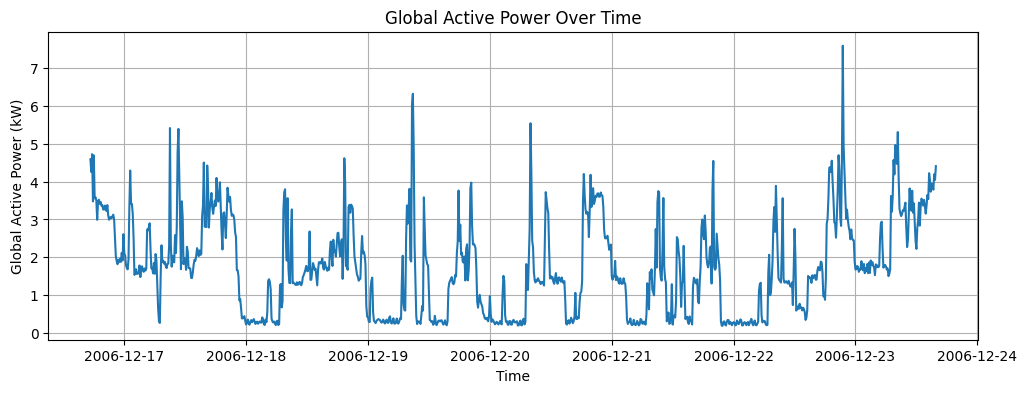

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘图总功率趋势
plt.figure(figsize=(12, 4))
plt.plot(df_10min.index[:1000], df_10min["Global_active_power"][:1000])
plt.title("Global Active Power Over Time")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.grid()
plt.show()


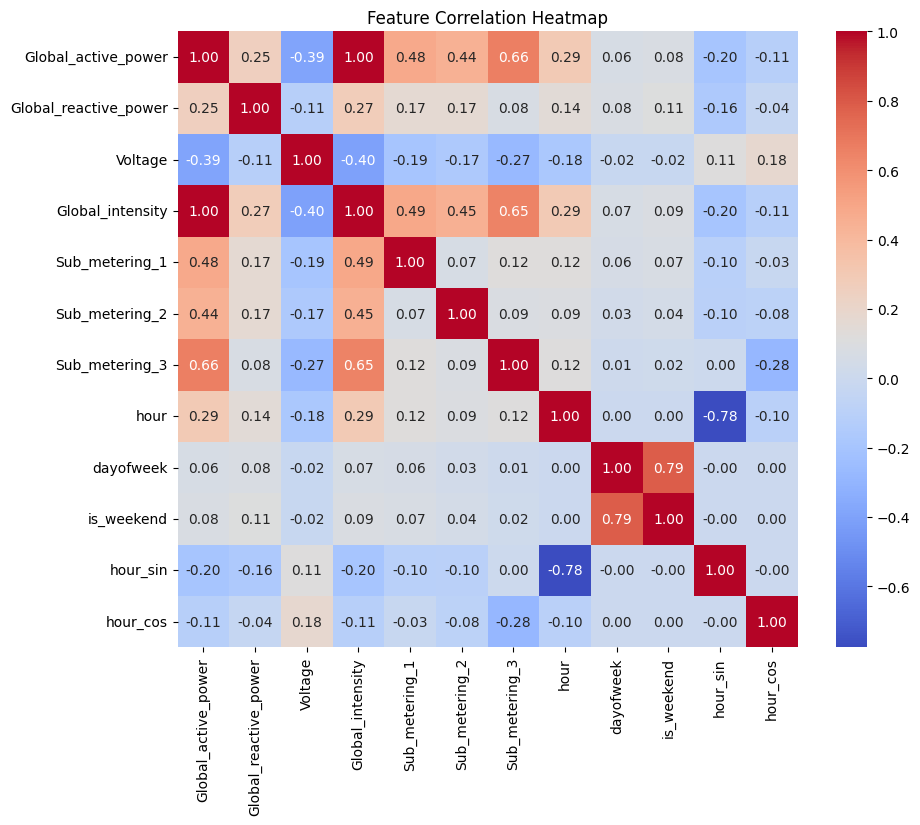

In [7]:
# 特征相关性热图
plt.figure(figsize=(10, 8))
corr = df_10min.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


## 2. 模型设计与实现（Model Implementation）

本节将实现四类模型：

- Transformer
- LSTM（RNN变体）
- CNN（用于时序建模）
- MLP（全连接神经网络）

我们将统一使用滑动窗口构造训练样本，预测未来1小时的总有功功率（Global_active_power）。


In [8]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# 设置预测目标和窗口参数
target_col = "Global_active_power"
input_window = 24 * 6  # 24小时，10分钟粒度 = 144
output_window = 6  # 预测未来1小时 = 6个10分钟
stride = 1

# 构造滑动窗口数据
class SequenceDataset(Dataset):
    def __init__(self, data, input_window, output_window, stride, target_idx):
        self.X = []
        self.Y = []
        for i in range(0, len(data) - input_window - output_window, stride):
            x = data[i:i + input_window]
            y = data[i + input_window:i + input_window + output_window, target_idx]
            self.X.append(x)
            self.Y.append(y)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.Y[idx], dtype=torch.float32)

# 获取数据
values = df_scaled.values
target_idx = df_scaled.columns.get_loc(target_col)

# 划分数据集
n = len(values)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

train_dataset = SequenceDataset(values[:train_end], input_window, output_window, stride, target_idx)
val_dataset = SequenceDataset(values[train_end:val_end], input_window, output_window, stride, target_idx)
test_dataset = SequenceDataset(values[val_end:], input_window, output_window, stride, target_idx)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


### 2.1 Transformer 模型

参考 Time Series Transformer，采用位置编码 + 多头注意力机制进行序列建模。


In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, output_len=6):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, output_len)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        out = self.decoder(x)
        return out


### 2.2 LSTM 模型

使用双层 LSTM 提取时间序列特征后进行回归。


In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_len=6):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_len)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out


### 2.3 CNN 模型

使用一维卷积网络进行时序建模。


In [11]:
class CNNModel(nn.Module):
    def __init__(self, input_dim, output_len=6):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(32, output_len)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        out = self.fc(x)
        return out


### 2.4 MLP 模型（Baseline）

将序列展平成向量后使用全连接网络。


In [12]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, seq_len, output_len=6):
        super().__init__()
        self.fc1 = nn.Linear(input_dim * seq_len, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_len)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


### 2.5 CNN + LSTM 混合模型

使用一维卷积提取局部时序特征，再用 LSTM 捕捉长期依赖。


In [22]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_dim, conv_channels, lstm_hidden_dim, lstm_layers, output_dim):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=conv_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=conv_channels, hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch, seq_len, features)
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.relu(self.conv1(x))  # (batch, channels, seq_len)
        x = x.permute(0, 2, 1)  # (batch, seq_len, channels)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # 只用最后一个时间步


### 2.6 Transformer + TCN 混合模型

使用 TCN 替代部分前置处理或位置编码，结合 Transformer 增强时序建模。


In [ ]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]


import torch
import torch.nn as nn

# 定义一个 Temporal Block
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, dropout):
        super(TemporalBlock, self).__init__()
        padding = (kernel_size - 1) * dilation

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        if self.downsample is not None:
            nn.init.kaiming_normal_(self.downsample.weight)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        if self.downsample is not None:
            x = self.downsample(x)

        # 修剪 out 以匹配 x 的时间维度
        min_len = min(out.size(2), x.size(2))
        return out[:, :, :min_len] + x[:, :, :min_len]

# 定义 TCN + Transformer 模型
class TCNTransformer(nn.Module):
    def __init__(self, input_dim, tcn_channels, d_model, nhead, num_layers, output_dim):
        super(TCNTransformer, self).__init__()
        self.tcn = TemporalBlock(input_dim, tcn_channels, kernel_size=3, stride=1, dilation=1, dropout=0.2)
        self.linear_proj = nn.Linear(tcn_channels, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_len, features)
        x = x.permute(0, 2, 1)                      # -> (batch_size, features, seq_len)
        x = self.tcn(x)                             # -> (batch_size, tcn_channels, seq_len)
        x = x.permute(0, 2, 1)                      # -> (batch_size, seq_len, tcn_channels)
        x = self.linear_proj(x)                     # -> (batch_size, seq_len, d_model)
        x = self.transformer_encoder(x)             # -> (batch_size, seq_len, d_model)
        x = self.decoder(x[:, -1, :])               # 取最后一个时间步输出进行预测
        return x



## 3. 模型训练与调参（Training & Hyperparameter Tuning）

我们将训练前面定义的四类模型，使用 MSE 作为损失函数，Adam 作为优化器。同时探索以下调参策略：

- 不同的学习率（lr）
- 不同的 batch size
- 模型结构参数（如 LSTM 层数、Transformer 头数等）
- 训练技巧：EarlyStopping、学习率衰减

训练集、验证集、测试集按比例 70%:15%:15% 划分。


In [31]:
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, device="cuda"):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    
    best_val_loss = float("inf")
    best_model = None
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                val_loss += criterion(output, y_batch).item()
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    model.load_state_dict(best_model)
    return model, train_losses, val_losses


### 3.1 训练各模型并记录结果


In [14]:
# 训练 Transformer 模型
input_dim = df_scaled.shape[1]
device = "cuda" if torch.cuda.is_available() else "cpu"

transformer = TransformerModel(input_dim=input_dim)
transformer_trained, transformer_train_loss, transformer_val_loss = train_model(
    transformer, train_loader, val_loader, epochs=30, lr=1e-3, device=device
)


Epoch 1/30, Train Loss: 0.0085, Val Loss: 0.0059
Epoch 2/30, Train Loss: 0.0059, Val Loss: 0.0055
Epoch 3/30, Train Loss: 0.0057, Val Loss: 0.0054
Epoch 4/30, Train Loss: 0.0055, Val Loss: 0.0057
Epoch 5/30, Train Loss: 0.0054, Val Loss: 0.0054
Epoch 6/30, Train Loss: 0.0052, Val Loss: 0.0054
Epoch 7/30, Train Loss: 0.0051, Val Loss: 0.0052
Epoch 8/30, Train Loss: 0.0050, Val Loss: 0.0054
Epoch 9/30, Train Loss: 0.0049, Val Loss: 0.0055
Epoch 10/30, Train Loss: 0.0047, Val Loss: 0.0053
Epoch 11/30, Train Loss: 0.0043, Val Loss: 0.0056
Epoch 12/30, Train Loss: 0.0042, Val Loss: 0.0056
Epoch 13/30, Train Loss: 0.0040, Val Loss: 0.0056
Epoch 14/30, Train Loss: 0.0039, Val Loss: 0.0056
Epoch 15/30, Train Loss: 0.0038, Val Loss: 0.0059
Epoch 16/30, Train Loss: 0.0036, Val Loss: 0.0057
Epoch 17/30, Train Loss: 0.0035, Val Loss: 0.0062
Epoch 18/30, Train Loss: 0.0034, Val Loss: 0.0060
Epoch 19/30, Train Loss: 0.0033, Val Loss: 0.0061
Epoch 20/30, Train Loss: 0.0032, Val Loss: 0.0064
Epoch 21/

In [15]:
# 训练 LSTM 模型
lstm = LSTMModel(input_dim=input_dim)
lstm_trained, lstm_train_loss, lstm_val_loss = train_model(
    lstm, train_loader, val_loader, epochs=30, lr=1e-3, device=device
)


Epoch 1/30, Train Loss: 0.0064, Val Loss: 0.0058
Epoch 2/30, Train Loss: 0.0058, Val Loss: 0.0055
Epoch 3/30, Train Loss: 0.0057, Val Loss: 0.0054
Epoch 4/30, Train Loss: 0.0055, Val Loss: 0.0053
Epoch 5/30, Train Loss: 0.0053, Val Loss: 0.0052
Epoch 6/30, Train Loss: 0.0052, Val Loss: 0.0051
Epoch 7/30, Train Loss: 0.0051, Val Loss: 0.0051
Epoch 8/30, Train Loss: 0.0050, Val Loss: 0.0051
Epoch 9/30, Train Loss: 0.0049, Val Loss: 0.0051
Epoch 10/30, Train Loss: 0.0048, Val Loss: 0.0051
Epoch 11/30, Train Loss: 0.0047, Val Loss: 0.0051
Epoch 12/30, Train Loss: 0.0046, Val Loss: 0.0052
Epoch 13/30, Train Loss: 0.0045, Val Loss: 0.0054
Epoch 14/30, Train Loss: 0.0044, Val Loss: 0.0053
Epoch 15/30, Train Loss: 0.0043, Val Loss: 0.0056
Epoch 16/30, Train Loss: 0.0042, Val Loss: 0.0055
Epoch 17/30, Train Loss: 0.0041, Val Loss: 0.0057
Epoch 18/30, Train Loss: 0.0040, Val Loss: 0.0056
Epoch 19/30, Train Loss: 0.0040, Val Loss: 0.0057
Epoch 20/30, Train Loss: 0.0039, Val Loss: 0.0060
Epoch 21/

In [16]:
# 训练 CNN 模型
cnn = CNNModel(input_dim=input_dim)
cnn_trained, cnn_train_loss, cnn_val_loss = train_model(
    cnn, train_loader, val_loader, epochs=30, lr=1e-3, device=device
)


Epoch 1/30, Train Loss: 0.0085, Val Loss: 0.0059
Epoch 2/30, Train Loss: 0.0059, Val Loss: 0.0056
Epoch 3/30, Train Loss: 0.0058, Val Loss: 0.0056
Epoch 4/30, Train Loss: 0.0057, Val Loss: 0.0055
Epoch 5/30, Train Loss: 0.0056, Val Loss: 0.0055
Epoch 6/30, Train Loss: 0.0056, Val Loss: 0.0056
Epoch 7/30, Train Loss: 0.0055, Val Loss: 0.0054
Epoch 8/30, Train Loss: 0.0055, Val Loss: 0.0054
Epoch 9/30, Train Loss: 0.0054, Val Loss: 0.0053
Epoch 10/30, Train Loss: 0.0054, Val Loss: 0.0053
Epoch 11/30, Train Loss: 0.0053, Val Loss: 0.0053
Epoch 12/30, Train Loss: 0.0053, Val Loss: 0.0053
Epoch 13/30, Train Loss: 0.0053, Val Loss: 0.0053
Epoch 14/30, Train Loss: 0.0053, Val Loss: 0.0053
Epoch 15/30, Train Loss: 0.0053, Val Loss: 0.0053
Epoch 16/30, Train Loss: 0.0052, Val Loss: 0.0053
Epoch 17/30, Train Loss: 0.0052, Val Loss: 0.0053
Epoch 18/30, Train Loss: 0.0052, Val Loss: 0.0054
Epoch 19/30, Train Loss: 0.0052, Val Loss: 0.0054
Epoch 20/30, Train Loss: 0.0052, Val Loss: 0.0053
Epoch 21/

In [ ]:
# 训练 MLP 模型
mlp = MLPModel(input_dim=input_dim, seq_len=input_window)
mlp_trained, mlp_train_loss, mlp_val_loss = train_model(
    mlp, train_loader, val_loader, epochs=30, lr=1e-3, device=device
)


Epoch 1/30, Train Loss: 0.0066, Val Loss: 0.0061
Epoch 2/30, Train Loss: 0.0059, Val Loss: 0.0058
Epoch 3/30, Train Loss: 0.0057, Val Loss: 0.0056
Epoch 4/30, Train Loss: 0.0056, Val Loss: 0.0055
Epoch 5/30, Train Loss: 0.0055, Val Loss: 0.0056
Epoch 6/30, Train Loss: 0.0054, Val Loss: 0.0055
Epoch 7/30, Train Loss: 0.0054, Val Loss: 0.0056
Epoch 8/30, Train Loss: 0.0053, Val Loss: 0.0055
Epoch 9/30, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 10/30, Train Loss: 0.0052, Val Loss: 0.0055
Epoch 11/30, Train Loss: 0.0050, Val Loss: 0.0054
Epoch 12/30, Train Loss: 0.0050, Val Loss: 0.0054
Epoch 13/30, Train Loss: 0.0050, Val Loss: 0.0055
Epoch 14/30, Train Loss: 0.0049, Val Loss: 0.0054
Epoch 15/30, Train Loss: 0.0049, Val Loss: 0.0055
Epoch 16/30, Train Loss: 0.0049, Val Loss: 0.0055
Epoch 17/30, Train Loss: 0.0049, Val Loss: 0.0055
Epoch 18/30, Train Loss: 0.0049, Val Loss: 0.0055
Epoch 19/30, Train Loss: 0.0048, Val Loss: 0.0055
Epoch 20/30, Train Loss: 0.0048, Val Loss: 0.0055
Epoch 21/

### 3.2 训练过程可视化

绘制训练与验证集 Loss 曲线，比较不同模型的收敛效果。


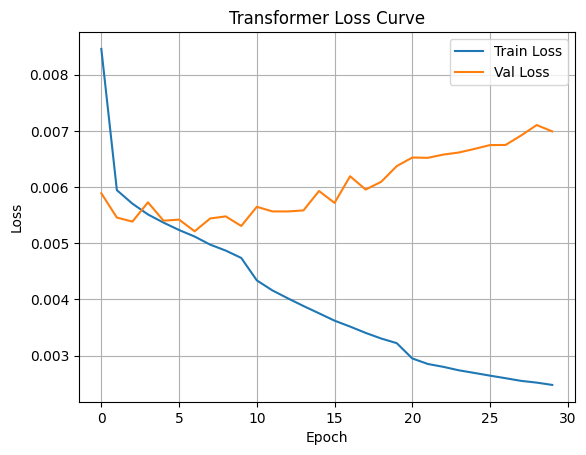

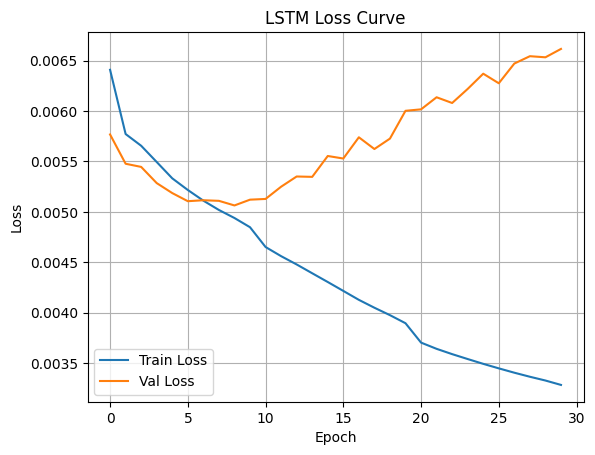

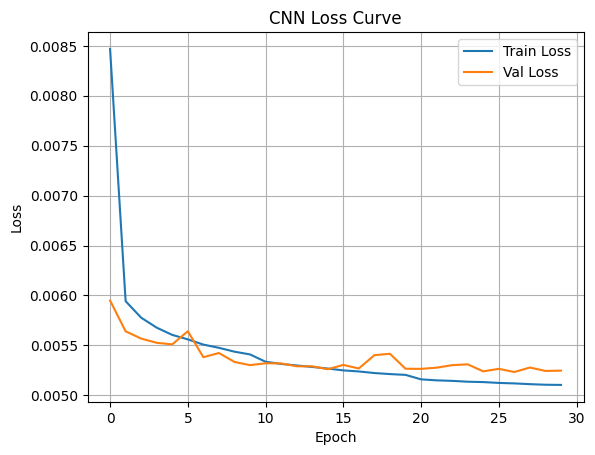

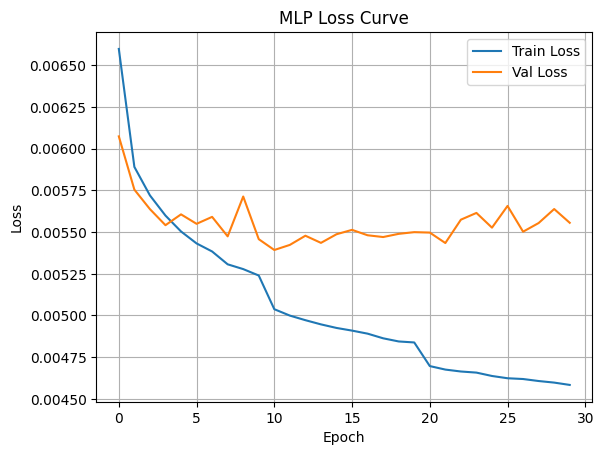

In [18]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, val_losses, model_name):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title(f"{model_name} Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(transformer_train_loss, transformer_val_loss, "Transformer")
plot_loss_curves(lstm_train_loss, lstm_val_loss, "LSTM")
plot_loss_curves(cnn_train_loss, cnn_val_loss, "CNN")
plot_loss_curves(mlp_train_loss, mlp_val_loss, "MLP")


### 3.3 混合模型训练（CNN+LSTM & Transformer+TCN）

为了进一步提升预测效果，我们尝试了两种融合模型：

- **CNN+LSTM**：结合 CNN 的局部特征提取能力与 LSTM 的时序建模能力。
- **Transformer+TCN**：用 TCN（因果卷积）对输入进行预处理，增强 Transformer 对时间顺序的建模。

我们使用相同的训练策略，对这两类模型进行训练。


In [27]:
# CNN+LSTM 模型训练
cnn_lstm = CNN_LSTM(input_dim=input_dim,
                    conv_channels=64,
                    lstm_hidden_dim=64,
                    lstm_layers=1,
                    output_dim=1)
cnn_lstm_trained, cnn_lstm_train_loss, cnn_lstm_val_loss = train_model(
    cnn_lstm, train_loader, val_loader, epochs=30, lr=1e-3, device=device
)


Epoch 1/30, Train Loss: 0.0064, Val Loss: 0.0062
Epoch 2/30, Train Loss: 0.0060, Val Loss: 0.0058
Epoch 3/30, Train Loss: 0.0059, Val Loss: 0.0058
Epoch 4/30, Train Loss: 0.0058, Val Loss: 0.0057
Epoch 5/30, Train Loss: 0.0057, Val Loss: 0.0058
Epoch 6/30, Train Loss: 0.0057, Val Loss: 0.0056
Epoch 7/30, Train Loss: 0.0056, Val Loss: 0.0057
Epoch 8/30, Train Loss: 0.0056, Val Loss: 0.0056
Epoch 9/30, Train Loss: 0.0055, Val Loss: 0.0058
Epoch 10/30, Train Loss: 0.0054, Val Loss: 0.0057
Epoch 11/30, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 12/30, Train Loss: 0.0052, Val Loss: 0.0058
Epoch 13/30, Train Loss: 0.0051, Val Loss: 0.0061
Epoch 14/30, Train Loss: 0.0050, Val Loss: 0.0057
Epoch 15/30, Train Loss: 0.0050, Val Loss: 0.0059
Epoch 16/30, Train Loss: 0.0049, Val Loss: 0.0061
Epoch 17/30, Train Loss: 0.0049, Val Loss: 0.0062
Epoch 18/30, Train Loss: 0.0048, Val Loss: 0.0063
Epoch 19/30, Train Loss: 0.0048, Val Loss: 0.0062
Epoch 20/30, Train Loss: 0.0047, Val Loss: 0.0063
Epoch 21/

In [34]:
# Transformer+TCN 模型训练
tcn_transformer = TCNTransformer(input_dim=input_dim,
                                 tcn_channels=64,
                                 d_model=64,
                                 nhead=4,
                                 num_layers=2,
                                 output_dim=1)
tcn_transformer_trained, tcn_transformer_train_loss, tcn_transformer_val_loss = train_model(
    tcn_transformer, train_loader, val_loader, epochs=30, lr=1e-3, device=device
)


TypeError: TCNTransformer.__init__() got an unexpected keyword argument 'input_dim'

### 3.4 混合模型训练过程可视化

下面绘制 CNN+LSTM 与 Transformer+TCN 的训练与验证 Loss 曲线，以直观比较其表现。


In [ ]:
plot_loss_curves(cnn_lstm_train_loss, cnn_lstm_val_loss, "CNN+LSTM")
plot_loss_curves(tcn_transformer_train_loss, tcn_transformer_val_loss, "Transformer+TCN")


## 4. 结果分析与创新探索（Evaluation & Innovation）

我们将评估各模型在测试集上的表现，计算 MSE、MAE、RMSE 等指标，并绘制预测结果对比图。同时进行深入分析与改进总结。


In [19]:
def evaluate_model(model, test_loader, device="cuda"):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch).cpu().numpy()
            preds.append(output)
            targets.append(y_batch.numpy())

    preds = np.concatenate(preds, axis=0)
    targets = np.concatenate(targets, axis=0)

    mse = mean_squared_error(targets, preds)
    mae = mean_absolute_error(targets, preds)
    rmse = np.sqrt(mse)
    
    return preds, targets, {"MSE": mse, "MAE": mae, "RMSE": rmse}


### 4.1 性能指标计算


In [20]:
transformer_preds, transformer_true, transformer_metrics = evaluate_model(transformer_trained, test_loader)
lstm_preds, lstm_true, lstm_metrics = evaluate_model(lstm_trained, test_loader)
cnn_preds, cnn_true, cnn_metrics = evaluate_model(cnn_trained, test_loader)
mlp_preds, mlp_true, mlp_metrics = evaluate_model(mlp_trained, test_loader)

print("Transformer:", transformer_metrics)
print("LSTM:", lstm_metrics)
print("CNN:", cnn_metrics)
print("MLP:", mlp_metrics)


Transformer: {'MSE': 0.005338696762919426, 'MAE': 0.04616660252213478, 'RMSE': np.float64(0.0730663859987575)}
LSTM: {'MSE': 0.004835571628063917, 'MAE': 0.043419256806373596, 'RMSE': np.float64(0.06953827455483719)}
CNN: {'MSE': 0.004022824112325907, 'MAE': 0.04149056598544121, 'RMSE': np.float64(0.06342573698685658)}
MLP: {'MSE': 0.004282387439161539, 'MAE': 0.041646216064691544, 'RMSE': np.float64(0.06543995292756206)}


### 4.2 预测结果对比图


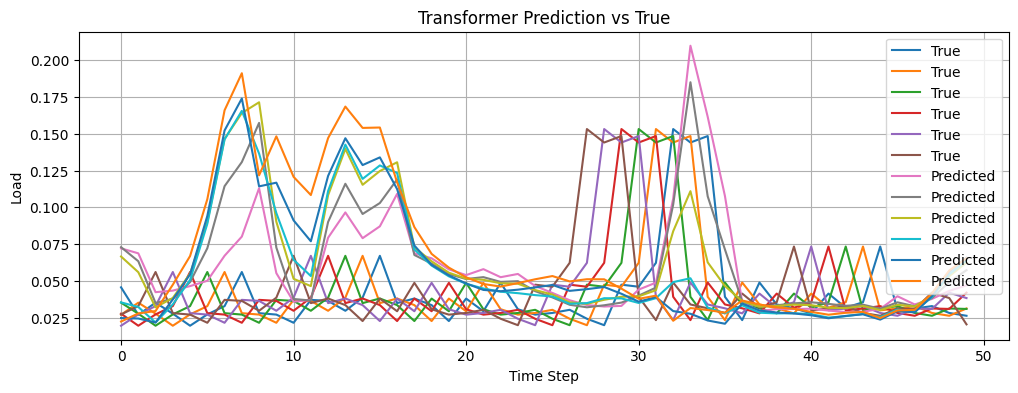

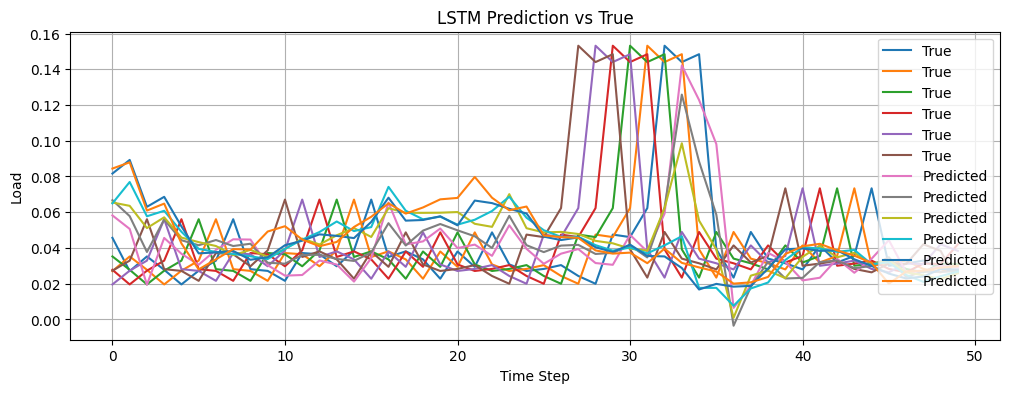

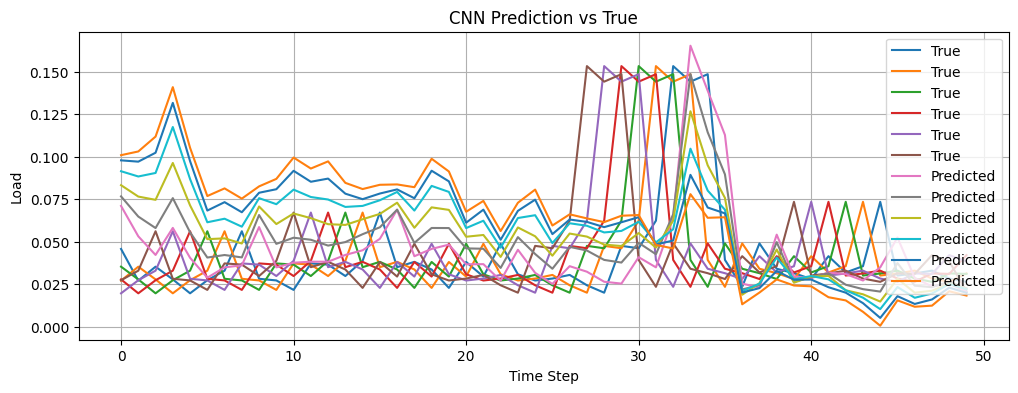

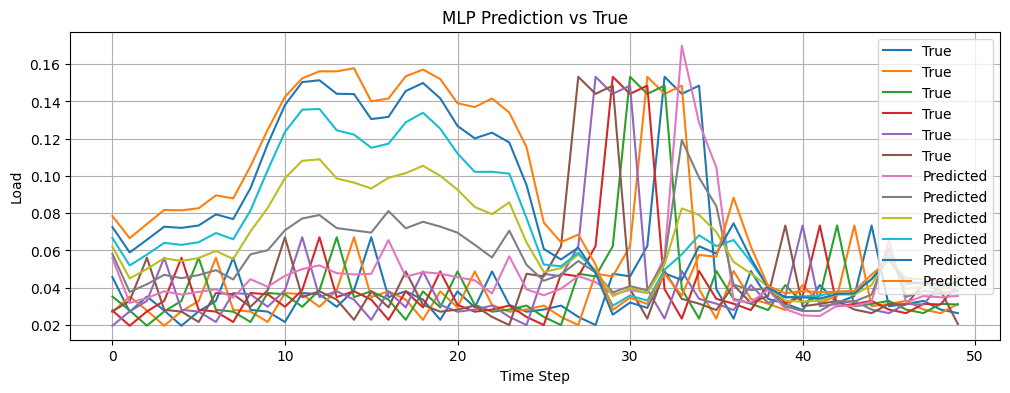

In [21]:
def plot_prediction(preds, targets, model_name, step=50):
    plt.figure(figsize=(12, 4))
    plt.plot(targets[:step], label="True")
    plt.plot(preds[:step], label="Predicted")
    plt.title(f"{model_name} Prediction vs True")
    plt.xlabel("Time Step")
    plt.ylabel("Load")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_prediction(transformer_preds, transformer_true, "Transformer")
plot_prediction(lstm_preds, lstm_true, "LSTM")
plot_prediction(cnn_preds, cnn_true, "CNN")
plot_prediction(mlp_preds, mlp_true, "MLP")


### 4.3 注意力权重可视化（仅限 Transformer）

可以可视化某一预测时间点对应的注意力权重，分析模型关注的历史时间点。
